<DIV ALIGN=CENTER>

# Introduction to Text Classification
## Professor Robert J. Brunner
  
</DIV>  
-----
-----


## Introduction

In this IPython Notebook, we introduce text classification. This is a
powerful, yet sometimes intimidating topic that finds applications in a
number of different areas: product reviews, sentiment analysis, and
document classification. Part of the challenge lies in the difficulty of
applying mathematical algorithms to (potentially very large) character
data sets. In Python, however, this challenge is considerably simplified
by using the nltk and the scikit learn machine learning libraries.

-----

In [22]:
# Set up Notebook

% matplotlib inline

# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# We do this to ignore several specific Pandas warnings
import warnings
warnings.filterwarnings("ignore")

### Data

To get started with text classification, we will analyze the [twenty
newsgroup][tng] data set. We first download this data (scikit learn has
built in methods for doing this, however, we have cached a copy locally
on our server). The data are made available via a custom object, but we
can access the data of interest by using dictionary keys. Before delving
into text data mining, we first explore this data over several code
cells to understand more about the task at hand.

-----

[tng]: http://kdd.ics.uci.edu/databases/20newsgroups/20newsgroups.data.html

In [23]:
# load dataset
from sklearn.datasets import fetch_20newsgroups

# Split into training and testing
train = fetch_20newsgroups(data_home='/home/data_scientist/data/textdm', subset='train', shuffle=True, random_state=23)
test = fetch_20newsgroups(data_home='/home/data_scientist/data/textdm', subset='test', shuffle=True, random_state=23)

In [24]:
# Exploratory Data Analysis
print("Number of Training Samples: {0}".format(len(train['data'])))
print("Number of Testing Samples: {0}".format(len(test['data'])))
print(40*'-')

for idx, label in enumerate(train['target_names']):
    print('Class {0:2d} = {1}'.format(idx, label))

Number of Training Samples: 11314
Number of Testing Samples: 7532
----------------------------------------
Class  0 = alt.atheism
Class  1 = comp.graphics
Class  2 = comp.os.ms-windows.misc
Class  3 = comp.sys.ibm.pc.hardware
Class  4 = comp.sys.mac.hardware
Class  5 = comp.windows.x
Class  6 = misc.forsale
Class  7 = rec.autos
Class  8 = rec.motorcycles
Class  9 = rec.sport.baseball
Class 10 = rec.sport.hockey
Class 11 = sci.crypt
Class 12 = sci.electronics
Class 13 = sci.med
Class 14 = sci.space
Class 15 = soc.religion.christian
Class 16 = talk.politics.guns
Class 17 = talk.politics.mideast
Class 18 = talk.politics.misc
Class 19 = talk.religion.misc


In [25]:
# Pick a single article and display information

item_number = 250
print("Class Number = {0}".format(train['target'][item_number]))
print("Class Name = {0}".format(train['target_names'][train['target'][item_number]]))
print("-"*70)
print(train['data'][item_number])

Class Number = 3
Class Name = comp.sys.ibm.pc.hardware
----------------------------------------------------------------------
From: rnichols@cbnewsg.cb.att.com (robert.k.nichols)
Subject: Re: how to search for bad memory chips.
Organization: AT&T
Distribution: na
Lines: 29

In article <N5s42B8w165w@c-cat.UUCP> david@c-cat.UUCP (Dave) writes:
>i came upon this idea i would like to share with everyone.
>
>to check for bad memory chips
>
>1. create a boot disk with emm386 himem.sys and ramdrive.sys in the
>   config/autoexec.bat.
>
>2. boot the PC to create a RAM drive as large as possible.
>
>3. use a disk repair utility ( I use NDD ). Run it on the RAM
>        drive, yes it will run, its only a device driver
>
>4. run 1000 or so passes, they go very quick
>
>5. if your machine fails, there is a definate bad memory chip
>
>6. if your machine passes, there is a conflict with programs you
>        are loading in memory.
...

It's an interesting idea, but the worst-case data patterns devel

-----

## Classification

In the [Lesson 1 Notebook: Introduction to Text Analysis][l1], we
identified the features (or tokens in the training documents) that we
should use to classify our documents. But this potential obscures the
challenge of actually classifying documents. Before introducing our
first classification technique, lets examine one document that is in our
test data set. 

Reviewing this single posting, we notice several issues that might
affect our classification process. First, if we remove the header,
footer, and quoted text, some message will have little to no signal. For
example, the message below would simply contain 'Calling Bill Gates,
calling Bill Gates....'. Second, if we don't remove this information,
our documents will include email address information (like com, edu,
etc.), proper names, and information such as dates or monetary
information. Finally, the content in some categories will clearly
overlap, such as _alt.atheism_ and _soc.religion.christian_. 

In the end, these issues demonstrate the **remaining need** for manual
intervention and introspection during the machine learning process. We
will continually want to analyze classification results to ensure we
understand what is occurring and why it is occurring.

-----
[l1]: intro2ta.ipynb

In [26]:
test_message = 100

print("Class Number = {0}".format(test['target'][test_message]))
print("Class Name = {0}".format(test['target_names'][test['target'][test_message]]))
print("-"*75)
print(test['data'][test_message])

Class Number = 6
Class Name = misc.forsale
---------------------------------------------------------------------------
From: jks2x@holmes.acc.Virginia.EDU (Jason K. Schechner)
Subject: Re: AN12 AIRCRAFT FOR SALE OR LEASING
Keywords: AIRCRAFT SALE
Organization: University of Virginia
Lines: 43

In article <AA9KerhuZ7@rtools.msk.su> slavik@rtools.msk.su writes:
>
>Our firm is in a position to either sell or lease  the serverses
>of one AN-12 air cargo transport aircraft  (with the complete
>technical repair in 1993 ).
>
>Terms of Delivery:
>
>1. The price of the aircraft is $840000.
>
>2. The price of leasing is $42800 per month with the guarantee
>    flight time more than 60 hours.
>
>    This price includes :
>        a) the price of the aircraft.
>        b) the price of insurance of the aircraft and the pilots.
>
>   The price of leasing does not include :
>        a) the fuel price.
>        b) the price of technical service.
>        c) taxes , airport taxes, air navigations expen

-----

### Naive Bayes Classifier

One of the (if not the) simplest techniques for perfomring text
classification is the [Naive Bayes classifier][nbd]. This technique is
popular, in part because of its simplicity, yet it also provides a quick
technique that can provide reasonable results. Fundamentally this method
applies Bayes theorem by (naively) assuming independence between the
features. In scikit learn, we will use a [Multinomial Naive Bayes][nbapi]
model, where we treat each feature independently. Thus we calculate the
likelihood of a feature corresponding to each training label, and the
accumulation of these likelihoods provides our overall classification.
By working with log-likelihoods, this accumulation becomes a simple sum.

-----

[nbd]: https://en.wikipedia.org/wiki/Naive_Bayes_classifier
[nbapi]: http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer

In [27]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

cv = CountVectorizer()

train_counts = cv.fit_transform(train['data'])
test_data = cv.transform(test['data'])

nb = MultinomialNB()

clf = nb.fit(train_counts, train['target'])
predicted = clf.predict(test_data)


print("NB prediction accuracy = {0:5.1f}%".format(100.0 * clf.score(test_data, test['target'])))

NB prediction accuracy =  77.3%


In [28]:
from sklearn.pipeline import Pipeline

tools = [('cv', CountVectorizer()), ('nb', MultinomialNB())]
clf = Pipeline(tools)

clf = clf.fit(train['data'], train['target'])
predicted = clf.predict(test['data'])

print("NB prediction accuracy = {0:5.1f}%".format(100.0 * clf.score(test['data'], test['target'])))

NB prediction accuracy =  77.3%


-----

We can also use the built-in `metrics` methods to display more
information about the classification results, including as a function of
the different labels.

-----

In [29]:
from sklearn import metrics
print(metrics.classification_report(test['target'], predicted,
    target_names = test['target_names']))

                          precision    recall  f1-score   support

             alt.atheism       0.79      0.77      0.78       319
           comp.graphics       0.67      0.74      0.70       389
 comp.os.ms-windows.misc       0.20      0.00      0.01       394
comp.sys.ibm.pc.hardware       0.56      0.77      0.65       392
   comp.sys.mac.hardware       0.84      0.75      0.79       385
          comp.windows.x       0.65      0.84      0.73       395
            misc.forsale       0.93      0.65      0.77       390
               rec.autos       0.87      0.91      0.89       396
         rec.motorcycles       0.96      0.92      0.94       398
      rec.sport.baseball       0.96      0.87      0.91       397
        rec.sport.hockey       0.93      0.96      0.95       399
               sci.crypt       0.67      0.95      0.78       396
         sci.electronics       0.79      0.66      0.72       393
                 sci.med       0.87      0.82      0.85       396
         

-----

We can also visually display the confusion matrix (where we show how
documents were misclassifid) by using Seaborn to create a heatmap visual.
First we create our confusion matrix method, which we subsequently use to
display the results from our Naive Bayes model.

-----

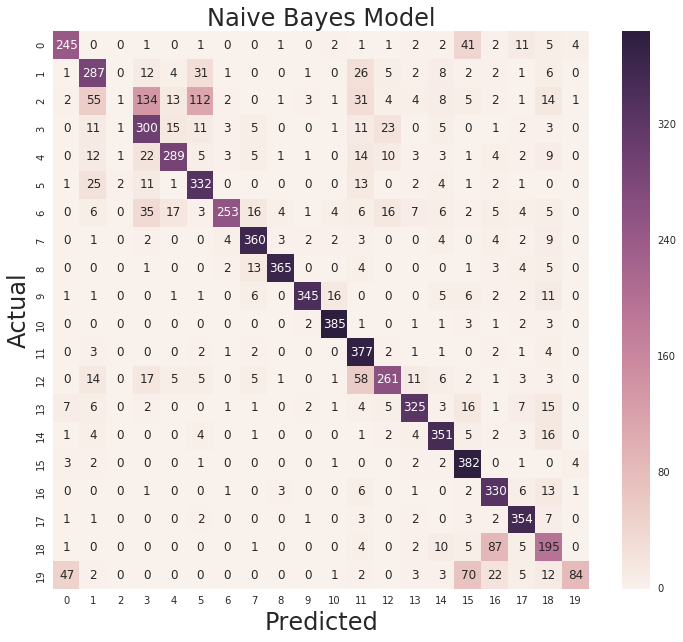

In [30]:
fig, ax = plt.subplots(figsize=(12, 10))

from helper_code import mlplots as mp
mp.confusion(test['target'], predicted, range(20), 20, 'Naive Bayes Model')

-----

### Student Activity

In the preceding cells, we used `CountVectorizer` to create a document
term matrix, and a Naive Bayes algorithm to classify new document by
using this DTM. Now that you have run the Notebook, go back and make the
following changes to see how the results change.

1. Change the `CountVectorizer` so that all words are changed to
lowercase. Does this change the classification results?
2. Change the `CountVectorizer` so that all accents are removed from
words. Does this change the classification results?
3. Change the smoothing parameter $\alpha$ for the `MultinomialNB`
classifier, from the default of one to zero and next some fractional
value between zero and one. How does this change the classification
results?

-----

## Stop Words

Text documents often contain many occurrences of the same word. For
example, in a document written in _English_, words such as _a_, _the_,
_of_, and _it_ likely occur very frequently. When classifying a document
based on the number of times specific words occur in the text document,
these words can lead to biases, especially since they are generally
common in **all** text documents you might want to classify. As a
result, the concept of [_stop words_][swd] was invented. Basically these
words are the most commonly occurring words that should be removed
during the tokenization process in order to improve subsequent
classification efforts. 

We can easily specify that the __English__ stop words should be excluded
during tokenization by using the `stop_words`. Note, _stop word_
dictionaries for other languages, or even specific domains, exist and
can be used instead. We demonstrate the removal of stop words by using a
`CountVectorizer` in the following simple example.

-----
[swd]: https://en.wikipedia.org/wiki/Stop_words

In [31]:
# Sample sentance to tokenize
my_text = 'INFO490 introduces many concepts in data science.'

cv1 = CountVectorizer(lowercase=True)
cv2 = CountVectorizer(stop_words = 'english', lowercase=True)

tk_func1 = cv1.build_analyzer()
tk_func2 = cv2.build_analyzer()

import pprint
pp = pprint.PrettyPrinter(indent=2, depth=1, width=80, compact=True)

print('Tokenization:')
pp.pprint(tk_func1(my_text))

print()

print('Tokenization (with Stop words):')
pp.pprint(tk_func2(my_text))

Tokenization:
['info490', 'introduces', 'many', 'concepts', 'in', 'data', 'science']

Tokenization (with Stop words):
['info490', 'introduces', 'concepts', 'data', 'science']


-----

### Stop words and Classification

Since _stop words_ are generally common across text documents, their
presence in a classification process likely to simply increase the noise.
As a result, by removing stop words, we likely will produce more
accurate classification. In the following code cell, we demonstrate the
removal of stop words in our classification pipeline, which, even with
this simple approach, increases the accuracy of our classification
results.

-----

In [33]:
# Modify parameters in out Pipeline and rerun.
# In this case, we set stop words 
clf.set_params(cv__stop_words = 'english')

clf = clf.fit(train['data'], train['target'])
predicted = clf.predict(test['data'])

print("NB (with Stop Words) prediction accuracy = {0:5.1f}%".format(100.0 * clf.score(test['data'], test['target'])))

NB (with Stop Words) prediction accuracy =  80.2%


-----

### Student Activity

In the preceding cells, we used stop words to remove common tokens from
a text document. Now that you have run the Notebook, go back and make
the following changes to see how the results change.

1. Create your own sentence, instead of the text associated with
`my_text`. Do the token results make sense with an without stop words
being used?
2. Using stop words, also change tokens to lowercase in the pipeline.
Does this change the classification results?
3. You can supply your own list of stop words, simply pass in a list of
string tokens (e.g., `['in', 'many']`). Try doing this with a sentence
of your own construction. Did the tokenization results agree with your
expectation

-----

## TF IFD

Previously, we have simply used the number of times a token (i.e., word,
or more generally an n-gram) occurs in a document to classify the
document. Even with the removal of stop words, however, this can still
overemphasize tokens that might generally occur across many documents
(e.g., names or general concepts). An alternative technique that often
provides robust improvements in classification accuracy is to employ the
frequency of token occurrence, normalized over the frequency with which
the token occurs in all documents. In this manner, we give higher weight
in the classification process to tokens that are more strongly tied to a
particular label. 

Formally this concept is known as [term frequency–inverse document
frequency][tfd] (or tf-idf), and scikit-learn provides this
functionality via the [`TfidfTransformer`][tftd] that can either follow
a tokenizer, such as `CountVectorizer` or can be combined together into
a single transformer via the [`TfidfVectorizer`][tfvd].

-----
[tfd]: https://en.wikipedia.org/wiki/Tf–idf

[tftd]: http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html

[tfvd]: http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer

tools = [('tf', TfidfVectorizer()), ('nb', MultinomialNB())]
clf = Pipeline(tools)
clf.set_params(tf__stop_words = 'english')

clf = clf.fit(train['data'], train['target'])
predicted = clf.predict(test['data'])

print("NB (TF-IDF with Stop Words) prediction accuracy = {0:5.1f}%".format(100.0 * clf.score(test['data'], test['target'])))

NB (TF-IDF with Stop Words) prediction accuracy =  81.7%


-----

## Document Classification

We now look at more advanced classification techniques than the Naive
Bayes classification technique that we employed in the previous Notebook.

### Linear SVM Classifier

One of the simplest classification techniques to understand is [support
vector machine][svmd], or SVM. SVM attempts to divide data by finding
(hyper-)planes that optimally differentiate data between classes. For
our text data mining, we can employ linear SVM for classification, known
as linear SVC, to classify text documents by their token feature
vectors. scikit_learn implements this technique in the [`LinearSVC`][lsvc] class.

-----
[lsvc]: http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html

[svmd]: https://en.wikipedia.org/wiki/Support_vector_machine

In [35]:
from sklearn import svm

tools = [('tf', TfidfVectorizer()), ('svm', svm.LinearSVC())]
clf = Pipeline(tools)

clf.set_params(tf__stop_words = 'english')
clf.set_params(svm__C = 1000)

clf = clf.fit(train['data'], train['target'])
predicted = clf.predict(test['data'])

print("SVM (TF-IDF with Stop Words) prediction accuracy = {0:5.1f}%".format(100.0 * clf.score(test['data'], test['target'])))

SVM (TF-IDF with Stop Words) prediction accuracy =  83.4%


In [36]:
from sklearn import metrics

print(metrics.classification_report(test['target'], predicted,
    target_names = test['target_names']))

                          precision    recall  f1-score   support

             alt.atheism       0.85      0.76      0.80       319
           comp.graphics       0.76      0.78      0.77       389
 comp.os.ms-windows.misc       0.72      0.70      0.71       394
comp.sys.ibm.pc.hardware       0.66      0.72      0.69       392
   comp.sys.mac.hardware       0.80      0.82      0.81       385
          comp.windows.x       0.83      0.74      0.78       395
            misc.forsale       0.73      0.84      0.78       390
               rec.autos       0.90      0.88      0.89       396
         rec.motorcycles       0.95      0.95      0.95       398
      rec.sport.baseball       0.90      0.93      0.92       397
        rec.sport.hockey       0.96      0.97      0.97       399
               sci.crypt       0.94      0.93      0.93       396
         sci.electronics       0.75      0.75      0.75       393
                 sci.med       0.91      0.85      0.87       396
         

-----

### SVM with SGD

We can use a [modified linear SVM][sgd] classifier that employs stochastic gradient
descent to quantify the loss for each sample, which is used to update
the classification model. Note for best results, we want our data to
have zero mean and unit variance for this technique to optimally work.
Since out text dta do not have this, we should expect suboptimal results.

-----
[sgd]: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html

In [37]:
from sklearn.linear_model import SGDClassifier

tools = [('tf', TfidfVectorizer()), ('sgd', SGDClassifier())]
clf = Pipeline(tools)

clf.set_params(tf__stop_words = 'english')

clf = clf.fit(train['data'], train['target'])
predicted = clf.predict(test['data'])

print("SGD (TF-IDF with Stop Words) prediction accuracy = {0:5.1f}%".format(100.0 * clf.score(test['data'], test['target'])))

SGD (TF-IDF with Stop Words) prediction accuracy =  85.0%


----

### Logistic Regression

[Logistic Regression][lrd] is typically employed on categorical
variables, such as yes/no decision, or win/loss likelihoods. In the case
of many labels, we can use the trick that logistic regressin can
quantify the likelihood a vector is in or out of a particular category.
Thus, by computing this over all categories we can determine the best
label for each test vector. [scikit_learn][sllr] provides an
implementation that can be easily used for our classification problem

-----

[lrd]: https://en.wikipedia.org/wiki/Logistic_regression
[sllr]: http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfTransformer

clf = Pipeline([('vect', CountVectorizer(stop_words = 'english')),
                ('tfidf', TfidfTransformer()),
                ('lr', LogisticRegression(C=1000))])


clf = clf.fit(train['data'], train['target'])
predicted = clf.predict(test['data'])

print("LR (TF-IDF with Stop Words) prediction accuracy = {0:5.1f}%".format(100.0 * clf.score(test['data'], test['target'])))


LR (TF-IDF with Stop Words) prediction accuracy =  84.9%


-----

### Student Activity

In the preceding cells, we introduced TF-IDF and demonstrated other,
more powerful classification algorithms to this text classification
problem. Now that you have run the Notebook, go back and make the
following changes to see how the results change.

1. Try changing the following parameters to `CountVectorizer` or
`TfidfVectorizer`: `lowercase`, `max_features`, `min_df` and `max_df`,
and `norm`. How do these attributes affect the performance of the
classification?

2. When using `LogisticRegression`, we did not employ any
regularization. Add a penalty term, `penalty='l1'` or `penalty='l2'` and
run the classification pipeline. How does this change the results? How
does this change the features identified by the algorithm?

3. Add a grid search to the pipeline for one particular classification
algorithm, for example, `SGDClassifier` to find the optimal set of
parameter to achieve the highest accuracy.

-----

## Sentiment Analysis

We now turn to classification problem where the goal is to classify
based on sentiment, negative or positive. We will approach this as a
simple classification problem (note, one can do more sophisticated
sentiment analysis based on the presence or absence of specific words).
We first load our data. In this case, however, we employ the scikit
learn data loading functionality to built training and testing data.

-----

In [39]:
import nltk
mvr = nltk.corpus.movie_reviews

from sklearn.datasets import load_files

data_dir = '/home/data_scientist/data/nltk_data/corpora/movie_reviews'
mvr = load_files(data_dir, shuffle = False)
print('Number of Reviews: {0}'.format(len(mvr.data)))

Number of Reviews: 2000


In [40]:
from sklearn.cross_validation import train_test_split

mvr_train, mvr_test, y_train, y_test = train_test_split(
    mvr.data, mvr.target, test_size=0.25, random_state=23)

-----

Now that the training and testing data have been loaded into the
notebook, we can build a simple pipeline by using a `CountVectorizer`
and `MultinomialNB` to build a document-term matrix and to perform a
Naive Bayes classification. With this simple approach, we easily obtain
reasonable results (over 80% accuracy). In the second code cell, we
display the top terms for each category.


-----

In [41]:
# Build simple pipeline

pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', MultinomialNB()),
])

# Build DTM and classify data
pipeline.fit(mvr_train, y_train)
y_pred = pipeline.predict(mvr_test)
print(metrics.classification_report(y_test, y_pred, target_names = mvr.target_names))

             precision    recall  f1-score   support

        neg       0.82      0.81      0.81       259
        pos       0.80      0.80      0.80       241

avg / total       0.81      0.81      0.81       500



In [42]:
# Display top terms per catgory.

top_count = 20
import numpy as np

# Extract pipeline steps.
nb = pipeline.steps[1][1]
cv = pipeline.steps[0][1]
features = cv.get_feature_names()

print('Label: Features')
print(75*'-')
for idx, target in enumerate(mvr.target_names):
    top_targets = np.argsort(nb.feature_log_prob_[idx])[-top_count:]
    top_features = " ".join(features[jdx] for jdx in top_targets)
    print('{0:5s}: {1}'.format(target, top_features))

Label: Features
---------------------------------------------------------------------------
neg  : be are movie on he his but film for this as with that it in is of to and the
pos  : one by are on but this he for film his with as that it in is to of and the


-----

### Student Activity

In the preceding cells, we used a simple pipeline to perform sentiment
analysis. Now that you have run the Notebook, go back and make the
following changes to see how the results change.

1. Use stop words in the `CountVectorizer`. How do the results,
including the top terms, change?
2. Change the vectorizer to TF-IDF. How do the results change (in
particular the top terms)?
3. Change the other TF-IDF parameters, such as `max_features` and
`lowercase`. How do the results change (including the top terms)?
4. Change the classifier to a more powerful algorithm. How do the
results change (in particular the top terms)?

Can you explain (feel free to use the class forums) why the
classification algorithm performed in the  manner it did ?

-----